**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
!pwd

/home/manu/tech/dev/ml/notebooks


In [5]:

PATH = "../data/bulldozers/"

df_raw = pd.read_feather('../tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

/home/manu/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [6]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [8]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [9]:
set_rf_samples(50000)

In [10]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20599951967256994, 0.24902215987248194, 0.9113115139140529, 0.8892550413747726, 0.8942521316111678]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [11]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.62 s, sys: 35.2 ms, total: 1.66 s
Wall time: 1.66 s


(9.297798165162774, 0.2977571048736288)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [12]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 129 ms, sys: 121 ms, total: 250 ms
Wall time: 830 ms


(9.297798165162774, 0.2977571048736288)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

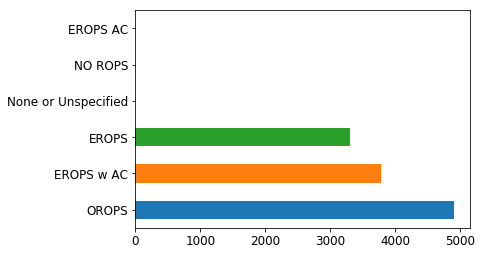

In [13]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [14]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.846253,0.283657
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574448,0.267137
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.686534,0.224236


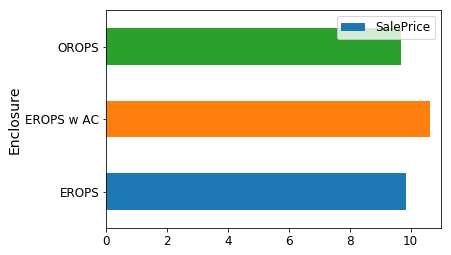

In [15]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

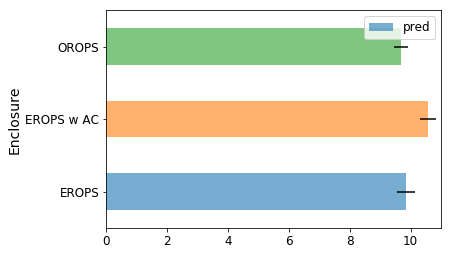

In [16]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

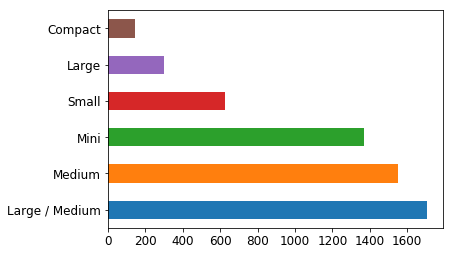

In [17]:
raw_valid.ProductSize.value_counts().plot.barh();

In [18]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.850445,0.342522
Large,10.470589,10.391540,0.379046
Large / Medium,10.691871,10.650668,0.295527
Medium,10.681511,10.622019,0.288231
Mini,9.535147,9.571539,0.267067
Small,10.324448,10.326454,0.309417


In [19]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.036476
Compact           0.034772
Small             0.029964
Mini              0.027902
Large / Medium    0.027747
Medium            0.027135
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [20]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.172523
37,Coupler_System,0.108379
13,ProductSize,0.095046
14,fiProductClassDesc,0.092497
2,ModelID,0.054256
39,Hydraulics_Flow,0.051755
63,saleElapsed,0.050050
10,fiSecondaryDesc,0.045083
38,Grouser_Tracks,0.044267
8,fiModelDesc,0.032316


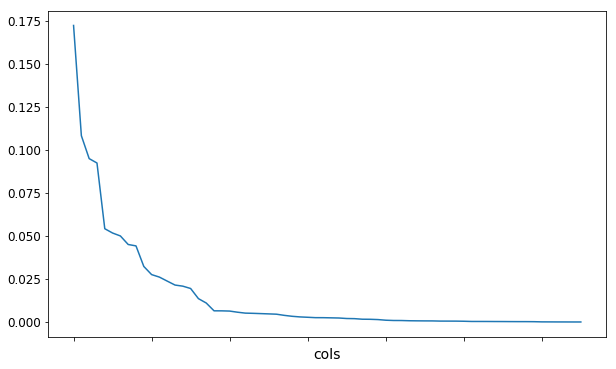

In [21]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [22]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

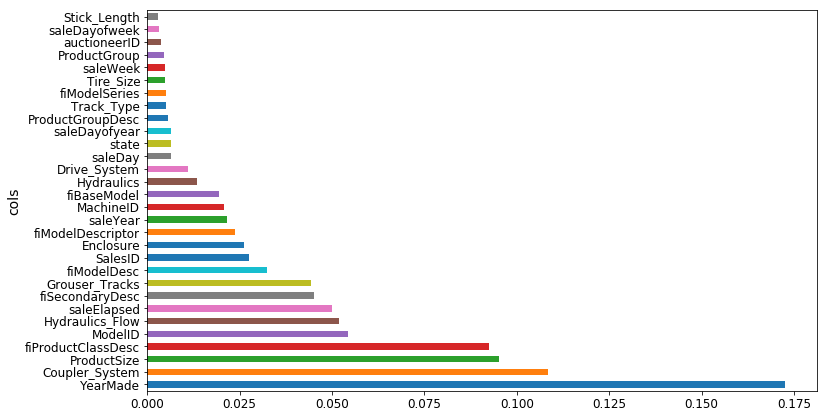

In [23]:
plot_fi(fi[:30]);

In [24]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [25]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2067275216938642, 0.24658082944151655, 0.9106835562930682, 0.8914158109484754, 0.8943218274064079]


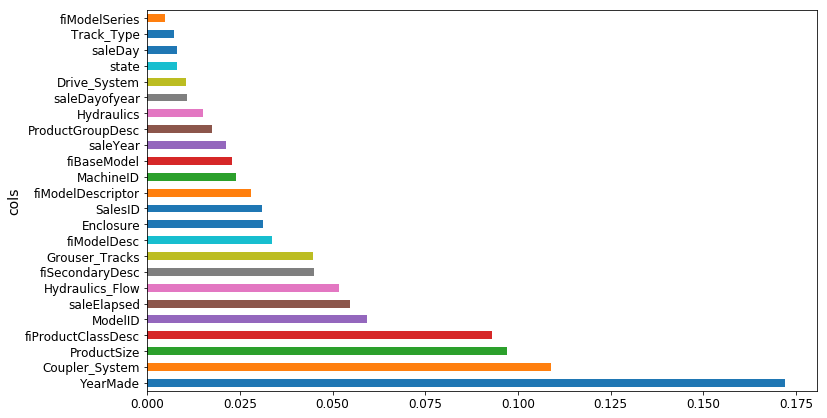

In [27]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

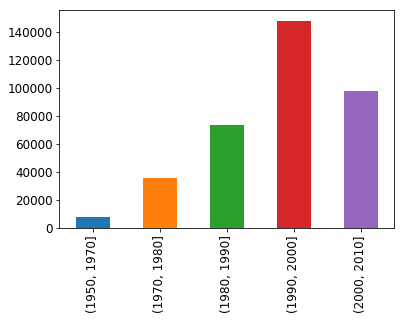

In [28]:
pd.cut(df_keep.YearMade, [1950, 1970, 1980, 1990, 2000, 2010]).value_counts().sort_index().plot.bar()

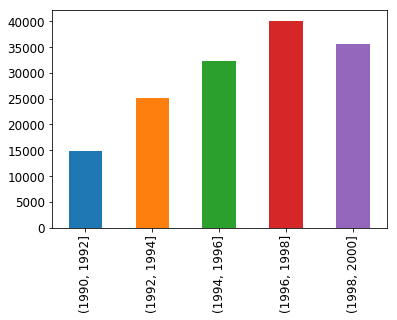

In [40]:
pd.cut(df_keep.YearMade, [1990,1992,1994,1996,1998,2000]).value_counts().sort_index().plot.bar()

In [30]:
df_nomil = df_raw[df_raw.YearMade!=1000]

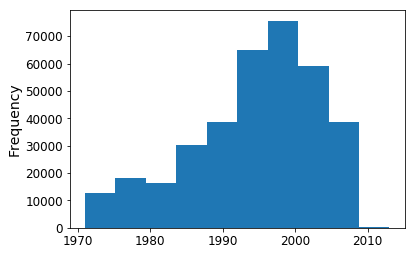

In [31]:
df_nomil[df_nomil.YearMade>1970].YearMade.plot.hist()

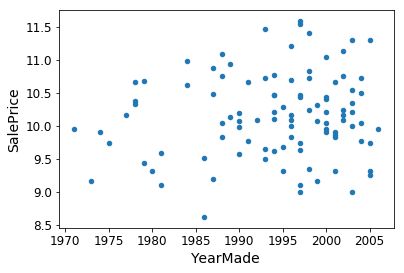

In [32]:
df_nomil[df_nomil.YearMade>1970].sample(100).plot.scatter(x='YearMade', y='SalePrice')

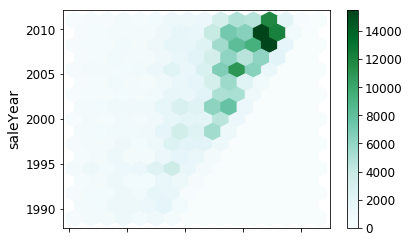

In [35]:
df_nomil[df_nomil.YearMade>1970].plot.hexbin(x='YearMade', y='saleYear', gridsize=15)

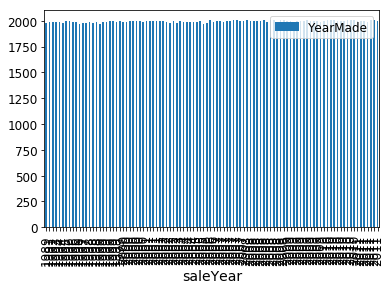

In [89]:
df_raw[df_raw.YearMade>1970][['saleYear','YearMade']].sample(100).set_index('saleYear').sort_values('saleYear').plot.bar(stacked=True)

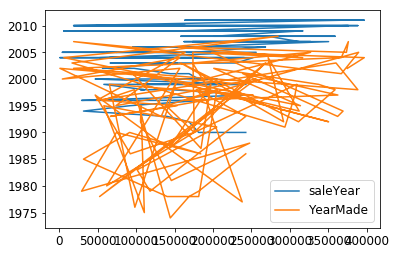

In [127]:
df_raw[df_raw.YearMade>1970][['saleYear','YearMade']].sample(100).sort_values('saleYear').plot.line()

In [116]:
df_raw[df_raw.YearMade == 2013]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
395524,6275685,10.915088,156521,1453,149,1.0,2013,NaN,-1,928GZ,...,7,2,341,False,False,False,False,False,False,1323216000


In [130]:
df_raw.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,1.427650e+05,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,4.011250e+05
mean,1.919713e+06,10.103096,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901,3.457955e+03,-0.623898,2004.095728,6.407035,26.179864,16.110402,2.600975,179.977581,1.091433e+09
std,9.090215e+05,0.693621,4.409920e+05,6221.777842,8.962237,16.976779,291.797469,2.759026e+04,0.870291,5.754190,3.424575,14.788059,8.427322,1.405763,103.559930,1.816977e+08
min,1.139246e+06,8.465900,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,-1.000000,1989.000000,1.000000,1.000000,1.000000,0.000000,2.000000,6.009984e+08
25%,1.418371e+06,9.581904,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00,-1.000000,2000.000000,3.000000,13.000000,9.000000,2.000000,84.000000,9.708768e+08
50%,1.639422e+06,10.085809,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00,-1.000000,2006.000000,6.000000,25.000000,16.000000,3.000000,168.000000,1.143072e+09
75%,2.242707e+06,10.596635,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,3.025000e+03,-1.000000,2009.000000,9.000000,39.000000,23.000000,3.000000,271.000000,1.237853e+09
max,6.333342e+06,11.863582,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,2.483300e+06,2.000000,2011.000000,12.000000,53.000000,31.000000,6.000000,365.000000,1.325203e+09


In [168]:
df_raw.MachineID.value_counts().reset_index(name="count").query("count > 5")[['index','count']]

,index,count
0,2283592,26
1,2285830,25
2,1942724,23
3,1896854,22
4,2296335,20
5,2277295,19
6,1746392,19
7,2014324,19
8,2296315,18
9,2273478,18


In [206]:
# categorical - nominal: datasource, auctioneerID, UsageBand
# categorical - ordinal: MachineID, ModelID, YearMade, MachineHoursCurrentMeter,saleYear, saleMonth, saleWeek, saleDay, saleDayofweek, saleDayofyear, saleElapsed
# numerical - discrete: SalePrice,
# numerical - continous/interval:
df_raw.MachineHoursCurrentMeter.value_counts().count()

15152

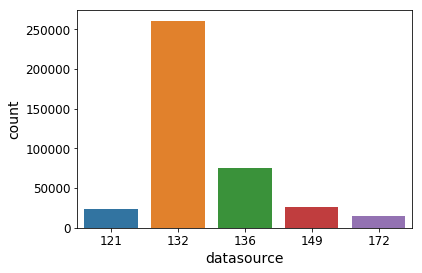

In [207]:
sns.countplot(df_raw['datasource'])

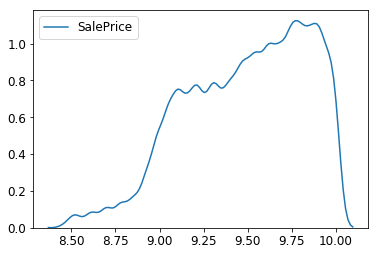

In [208]:
sns.kdeplot(df_raw.query('SalePrice < 10').SalePrice)

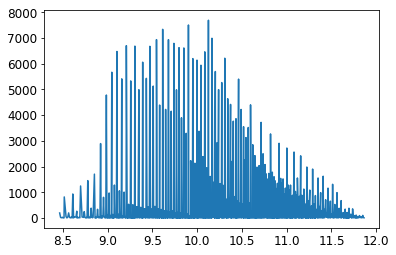

In [209]:
df_raw.SalePrice.value_counts().sort_index().plot.line()

/home/manu/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


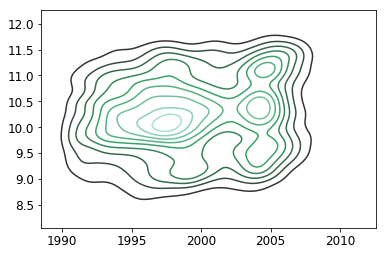

In [211]:
sns.kdeplot(df_raw[df_raw['YearMade'] > 1990].loc[:, ['YearMade', 'SalePrice']].dropna().sample(5000))

/home/manu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


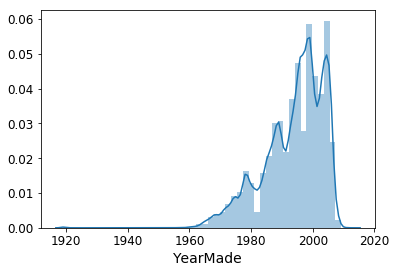

In [217]:
sns.distplot(df_raw[df_raw['YearMade'] > 1000]['YearMade'], bins=50, kde=True)

/home/manu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/manu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


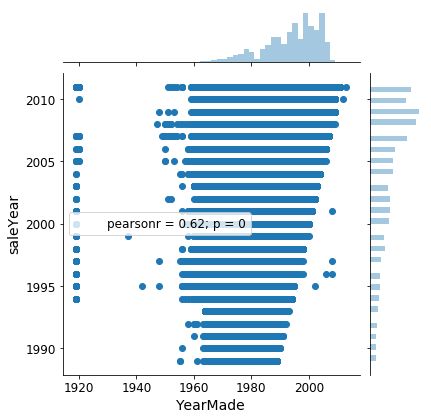

In [218]:
sns.jointplot(x='YearMade', y='saleYear', data=df_raw[df_raw['YearMade'] > 1000])

/home/manu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/manu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


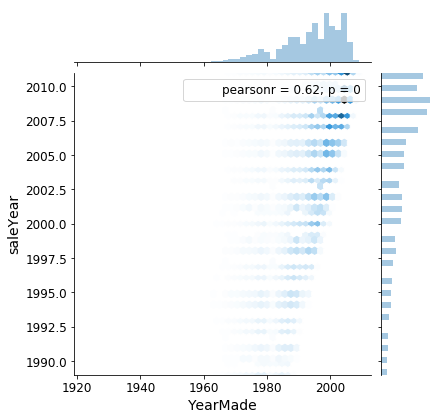

In [220]:
sns.jointplot(x='YearMade', y='saleYear', data=df_raw[df_raw['YearMade'] > 1000], kind='hex')

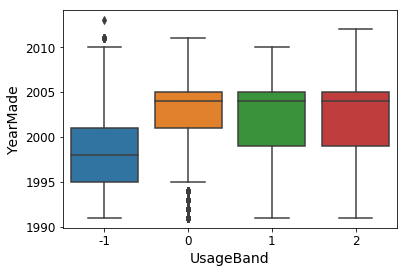

In [223]:
sns.boxplot(
    x='UsageBand',
    y='YearMade',
    data=df_nomil[df_nomil['YearMade'] > 1990]
)

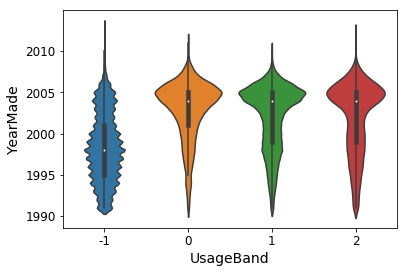

In [226]:
sns.violinplot(
    x='UsageBand',
    y='YearMade',
    data=df_nomil[df_nomil['YearMade'] > 1990]
)

In [ ]:
# categorical - nominal: datasource, auctioneerID, UsageBand
# categorical - ordinal: MachineID, ModelID, YearMade, MachineHoursCurrentMeter,saleYear, saleMonth, saleWeek, saleDay, saleDayofweek, saleDayofyear, saleElapsed
# numerical - discrete: SalePrice,
# numerical - continous/interval:

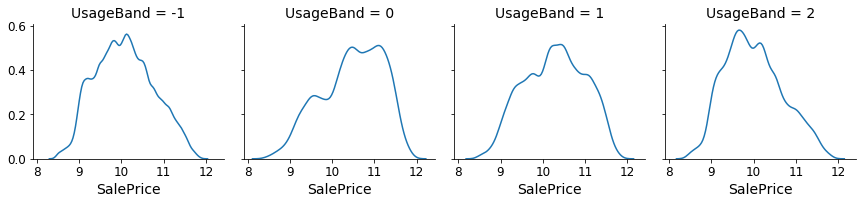

In [228]:
g = sns.FacetGrid(df_raw, col="UsageBand", col_wrap=6)
g.map(sns.kdeplot, "SalePrice")

/home/manu/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


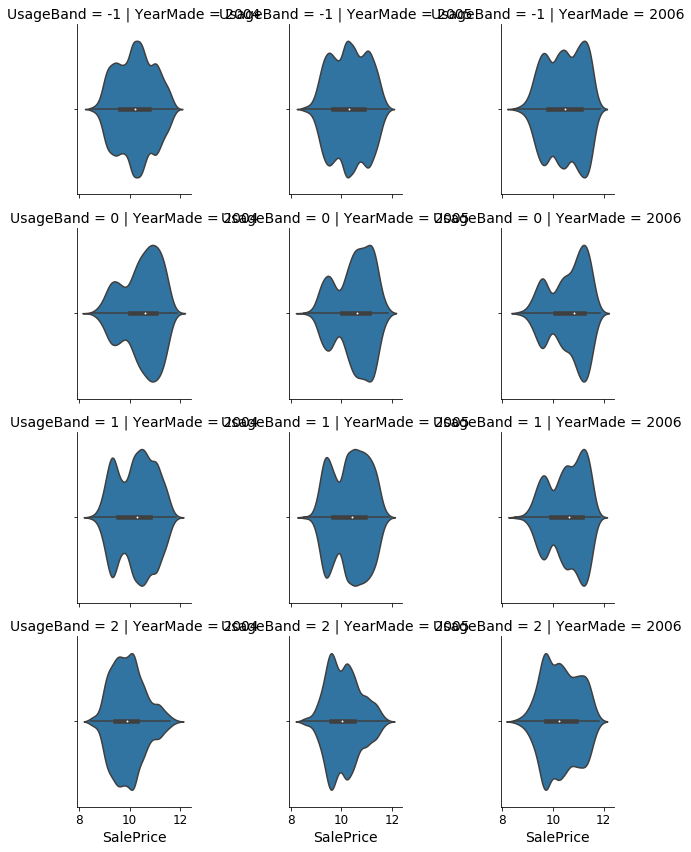

In [235]:
df_grid = df_raw[df_raw['YearMade'].isin(['2004', '2005', '2006'])]

g = sns.FacetGrid(df_grid, row="UsageBand", col="YearMade")
g.map(sns.violinplot, "SalePrice")

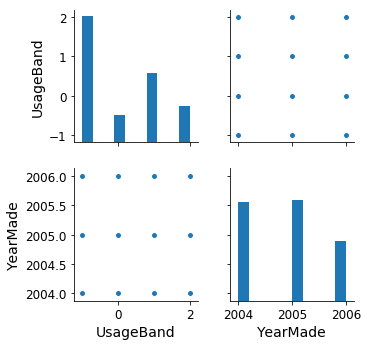

In [240]:

#
#
# Pair plots are most useful when just starting out with a dataset, because they help contextualize relationships within it.
#
#


sns.pairplot(df_grid[['UsageBand', 'YearMade']])

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [32]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20735855424721394, 0.2539014356472461, 0.9101374499546792, 0.8848727086216444, 0.8924332850917236]


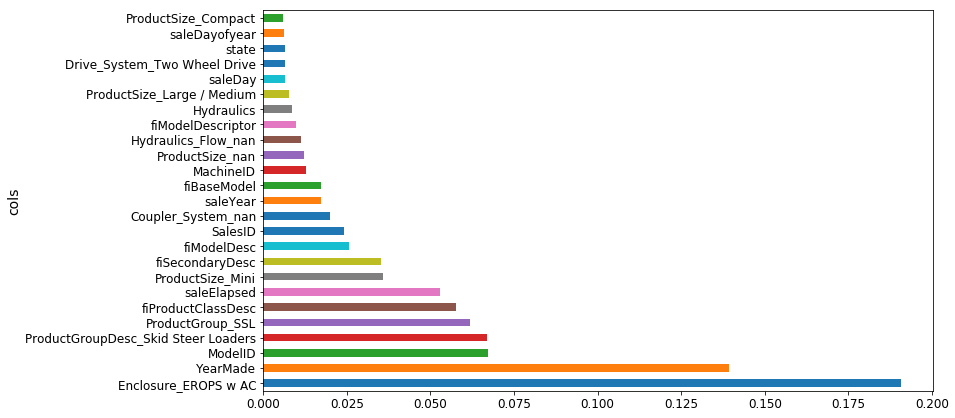

In [33]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [34]:
from scipy.cluster import hierarchy as hc

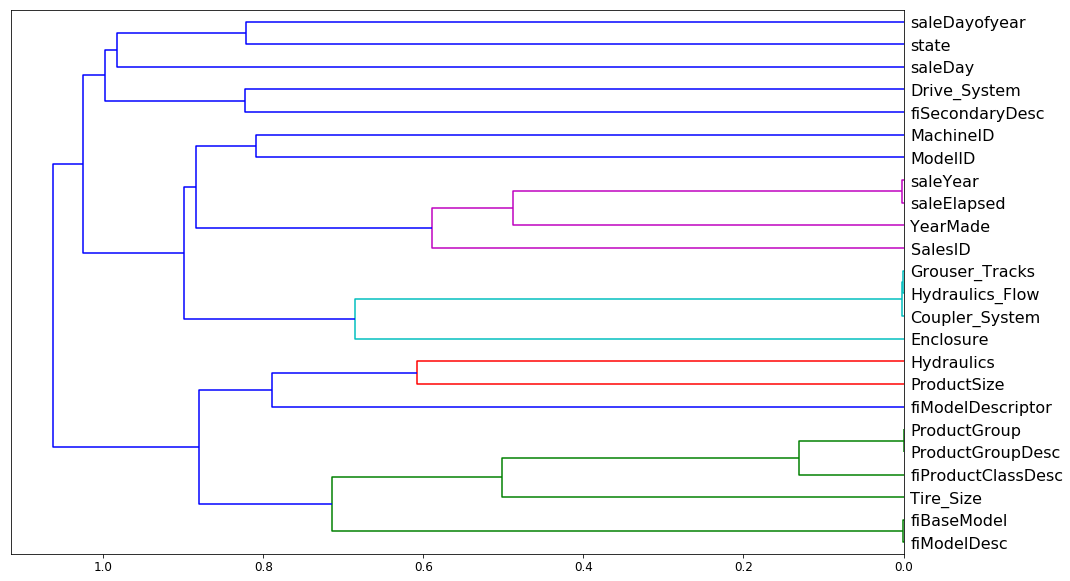

In [35]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [36]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [37]:
get_oob(df_keep)

0.89043500543033

Now we try removing each variable one at a time.

In [38]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8891719460130927
saleElapsed 0.8874480052763367
fiModelDesc 0.8890779634474197
fiBaseModel 0.888619564362102
Grouser_Tracks 0.890751673737816
Coupler_System 0.8899328961602866


It looks like we can try one from each group for removal. Let's see what that does.

In [39]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8885451732184905

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [40]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [41]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

FileNotFoundError: [Errno 2] No such file or directory: 'tmp/keep_cols.npy'

In [ ]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [ ]:
reset_rf_samples()

In [ ]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

# Partial dependence

In [ ]:
from pdpbox import pdp
from plotnine import *

In [ ]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [ ]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

In [ ]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

In [ ]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [ ]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [ ]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [ ]:
plot_pdp('YearMade')

In [ ]:
plot_pdp('YearMade', clusters=5)

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

In [ ]:
idxs = np.argsort(contributions[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

In [ ]:
contributions[0].sum()

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

In [ ]:
(X_valid[feats]/1000).describe()

In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)